In [1]:
# Ensure project root is importable
import sys
from pathlib import Path
proj_root = Path.cwd().parent  # notebooks/ -> project root
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))
print("Python exec:", sys.executable)
print("Added to sys.path:", proj_root)

# After this, imports like `from multipong.ai import ...` should work.


Python exec: d:\projekty\multipong\.venv\Scripts\python.exe
Added to sys.path: d:\projekty\multipong


## 1. Importy a příprava

In [2]:
import numpy as np
import random
import pickle
from pathlib import Path
from multipong.ai import RLPongEnv, encode_state, update_q_value, get_q_value

# Nastavení seed pro reprodukovatelnost
random.seed(42)
np.random.seed(42)

In [15]:
# Nastavení perzistence UI voleb
import json
SETTINGS_PATH = proj_root / "notebooks/rl_ui_settings.json"

def load_settings():
    try:
        if SETTINGS_PATH.exists():
            with open(SETTINGS_PATH, "r", encoding="utf-8") as f:
                return json.load(f)
    except Exception as e:
        print(f"⚠️ Nelze načíst nastavení: {e}")
    return {}

def save_settings(data: dict):
    try:
        with open(SETTINGS_PATH, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
    except Exception as e:
        print(f"⚠️ Nelze uložit nastavení: {e}")

def update_settings(**kwargs):
    data = load_settings()
    data.update(kwargs)
    save_settings(data)

## 2. Inicializace prostředí a hyperparametrů

In [3]:
# Prostředí
env = RLPongEnv(width=400, height=300, paddle_height=60, ball_speed=4)

# Hyperparametry Q-learningu
episodes = 2000
alpha = 0.15      # Learning rate
gamma = 0.95      # Discount factor
epsilon = 0.2     # Exploration rate
decay = 0.995     # Epsilon decay (pokud chceš snižovat exploraci)
num_bins = 8      # Počet binů pro diskretizaci

# Akce
ACTIONS = [0, 1, 2]  # 0=stay, 1=up, 2=down

# Q-tabulka
Q = {}

print(f"🎮 Trénink RL agenta na RLPongEnv")
print(f"📊 Hyperparametry: α={alpha}, γ={gamma}, ε={epsilon}")
print(f"🔁 Epizod: {episodes}")

🎮 Trénink RL agenta na RLPongEnv
📊 Hyperparametry: α=0.15, γ=0.95, ε=0.2
🔁 Epizod: 2000


## 3. Tréninková smyčka Q-learningu

In [4]:
rewards_per_episode = []
current_epsilon = epsilon

for ep in range(episodes):
    state = env.reset()
    state_key = encode_state(state, env, num_bins=num_bins)
    total_reward = 0
    steps = 0

    done = False
    while not done and steps < 500:  # max 500 kroků na epizodu
        # Epsilon-greedy: explorace vs. exploatace
        if random.random() < current_epsilon:
            action_idx = random.randint(0, len(ACTIONS) - 1)
        else:
            q_vals = get_q_value(Q, state_key)
            action_idx = int(np.argmax(q_vals))

        action = ACTIONS[action_idx]
        next_state, reward, done = env.step(action)
        total_reward += reward
        steps += 1

        next_state_key = encode_state(next_state, env, num_bins=num_bins)

        # Q-learning update
        update_q_value(Q, state_key, action_idx, next_state_key, reward, alpha=alpha, gamma=gamma)

        state_key = next_state_key

    rewards_per_episode.append(total_reward)
    current_epsilon *= decay  # Snižuj exploraci

    # Progress report
    if (ep + 1) % 200 == 0:
        avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"Ep {ep+1:4d}/{episodes} | Avg reward (100): {avg_reward:7.2f} | ε: {current_epsilon:.4f}")

print(f"✅ Trénink dokončen! Q-tabulka má {len(Q)} stavů.")

Ep  200/2000 | Avg reward (100):   -2.01 | ε: 0.0734
Ep  400/2000 | Avg reward (100):    0.06 | ε: 0.0269
Ep  400/2000 | Avg reward (100):    0.06 | ε: 0.0269
Ep  600/2000 | Avg reward (100):    0.90 | ε: 0.0099
Ep  600/2000 | Avg reward (100):    0.90 | ε: 0.0099
Ep  800/2000 | Avg reward (100):    1.52 | ε: 0.0036
Ep  800/2000 | Avg reward (100):    1.52 | ε: 0.0036
Ep 1000/2000 | Avg reward (100):    2.00 | ε: 0.0013
Ep 1000/2000 | Avg reward (100):    2.00 | ε: 0.0013
Ep 1200/2000 | Avg reward (100):    2.00 | ε: 0.0005
Ep 1200/2000 | Avg reward (100):    2.00 | ε: 0.0005
Ep 1400/2000 | Avg reward (100):    2.00 | ε: 0.0002
Ep 1400/2000 | Avg reward (100):    2.00 | ε: 0.0002
Ep 1600/2000 | Avg reward (100):    2.00 | ε: 0.0001
Ep 1600/2000 | Avg reward (100):    2.00 | ε: 0.0001
Ep 1800/2000 | Avg reward (100):    2.00 | ε: 0.0000
Ep 1800/2000 | Avg reward (100):    2.00 | ε: 0.0000
Ep 2000/2000 | Avg reward (100):    2.00 | ε: 0.0000
✅ Trénink dokončen! Q-tabulka má 15 stavů.
Ep 

## 4. Analýza výsledků

In [5]:
# Statistika
print(f"\n📈 Statistika tréninku:")
print(f"  Počet stavů v Q-tabulce: {len(Q)}")
print(f"  Počet akcí: {len(ACTIONS)}")
print(f"  Průměrná odměna (prvních 100): {np.mean(rewards_per_episode[:100]):.2f}")
print(f"  Průměrná odměna (posledních 100): {np.mean(rewards_per_episode[-100:]):.2f}")
print(f"  Min. odměna: {np.min(rewards_per_episode):.2f}")
print(f"  Max. odměna: {np.max(rewards_per_episode):.2f}")


📈 Statistika tréninku:
  Počet stavů v Q-tabulce: 15
  Počet akcí: 3
  Průměrná odměna (prvních 100): -3.85
  Průměrná odměna (posledních 100): 2.00
  Min. odměna: -5.00
  Max. odměna: 2.00


## 5. Vizualizace křivky učení

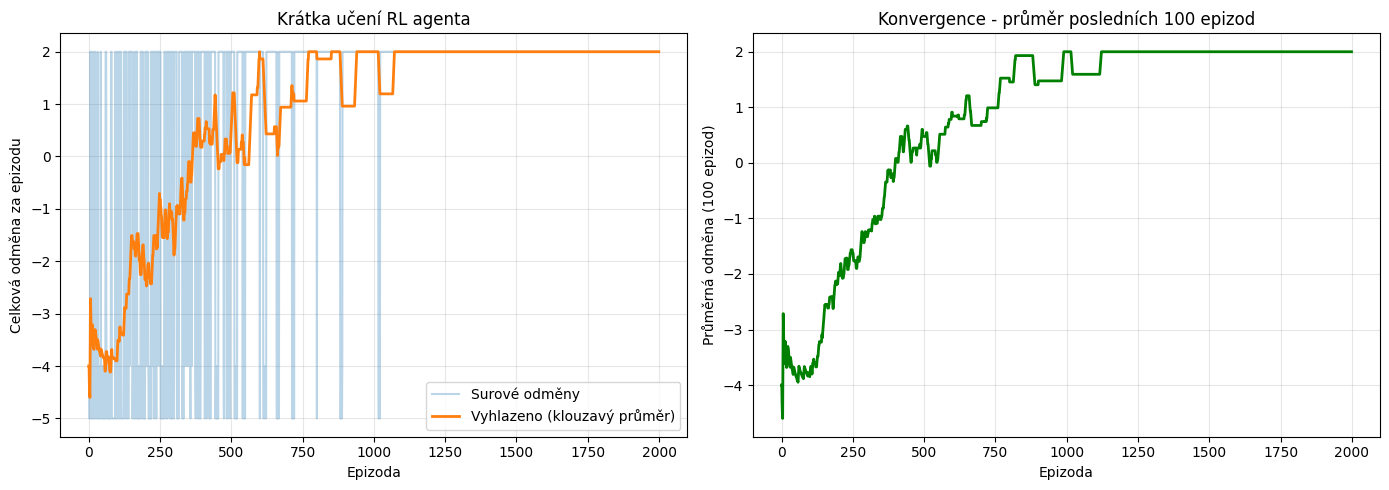

✅ Grafy vykresleny


In [6]:
try:
    import matplotlib.pyplot as plt

    # Vyhlazená křivka (klouzavý průměr)
    window = 50
    smoothed = [
        np.mean(rewards_per_episode[max(0, i - window) : i + 1])
        for i in range(len(rewards_per_episode))
    ]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Graf 1: Surové a vyhlazené odměny
    axes[0].plot(rewards_per_episode, alpha=0.3, label="Surové odměny")
    axes[0].plot(smoothed, linewidth=2, label="Vyhlazeno (klouzavý průměr)")
    axes[0].set_xlabel("Epizoda")
    axes[0].set_ylabel("Celková odměna za epizodu")
    axes[0].set_title("Krátka učení RL agenta")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Graf 2: Průměr posledních N epizod
    window2 = 100
    running_avg = [
        np.mean(rewards_per_episode[max(0, i - window2) : i + 1])
        for i in range(len(rewards_per_episode))
    ]
    axes[1].plot(running_avg, linewidth=2, color="green")
    axes[1].set_xlabel("Epizoda")
    axes[1].set_ylabel("Průměrná odměna (100 epizod)")
    axes[1].set_title("Konvergence - průměr posledních 100 epizod")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("✅ Grafy vykresleny")

except ImportError:
    print("⚠️ matplotlib není nainstalován, grafy se nevykresluji")

## 6. Evaluace natrénovaného agenta

In [ ]:
# Evaluace bez explorace (pure exploitation)
eval_episodes = 100
eval_rewards = []

for ep in range(eval_episodes):
    state = env.reset()
    state_key = encode_state(state, env, num_bins=num_bins)
    total_reward = 0
    done = False
    steps = 0

    while not done and steps < 500:
        # Vždy zvolíme best action (greedy)
        q_vals = get_q_value(Q, state_key)
        action_idx = int(np.argmax(q_vals))
        action = ACTIONS[action_idx]

        next_state, reward, done = env.step(action)
        total_reward += reward
        steps += 1

        state_key = encode_state(next_state, env, num_bins=num_bins)

    eval_rewards.append(total_reward)

print(f"\n🎯 EVALUACE (bez explorace):")
print(f"  Epizod: {eval_episodes}")
print(f"  Průměrná odměna: {np.mean(eval_rewards):.2f}")
print(f"  Std. dev: {np.std(eval_rewards):.2f}")
print(f"  Min: {np.min(eval_rewards):.2f}")
print(f"  Max: {np.max(eval_rewards):.2f}")

## 7. Uložení modelu

In [10]:
# Vytvoř složku pro modely v kořeni projektu
models_dir = (proj_root / "multipong/ai/models")
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "q_table_pong.pkl"

# Ulož Q-tabulku
with open(model_path, "wb") as f:
    pickle.dump(Q, f)

print(f"✅ Model uložen: {model_path}")
print(f"   Velikost: {model_path.stat().st_size / 1024:.1f} KB")

✅ Model uložen: d:\projekty\multipong\multipong\ai\models\q_table_pong.pkl
   Velikost: 1.0 KB


## 8. Načtení a test

In [11]:
# Vyzkoušej načtení modelu (fallback, pokud není definován model_path)
from pathlib import Path
import numpy as np
if 'model_path' not in globals():
    model_path = (proj_root / "multipong/ai/models/q_table_pong.pkl")

with open(model_path, "rb") as f:
    Q_loaded = pickle.load(f)

print(f"✅ Model načten zpět!")
print(f"   Stavů v Q-tabulce: {len(Q_loaded)}")

# Robustní porovnání Q-tabulek (klíče i hodnoty)

def q_tables_equal(q1, q2):
    if q1.keys() != q2.keys():
        return False
    for k in q1.keys():
        a1 = np.asarray(q1[k])
        a2 = np.asarray(q2[k])
        if a1.shape != a2.shape:
            return False
        if not np.allclose(a1, a2):
            return False
    return True

identical = q_tables_equal(Q, Q_loaded)
print(f"   Kontrola: Q-tabulka je identická: {identical}")

✅ Model načten zpět!
   Stavů v Q-tabulce: 15
   Kontrola: Q-tabulka je identická: True


## 9. Integrace s QLearningAI (demo)

Níže přímo vytvoříme instanci `QLearningAI` s uloženým modelem a ukážeme krátkou evaluaci v `RLPongEnv` bez explorace (ε=0).

In [12]:
# Demo: QLearningAI s uloženým modelem v RLPongEnv
from multipong.ai.qlearning_ai import QLearningAI

# Vytvoř instanci QLearningAI s nulovou explorací a načti model
ai = QLearningAI(model_path=str(model_path), epsilon=0.0)
print(f"🤖 QLearningAI načetl {len(ai.Q)} stavů z modelu")

# Krátká evaluace pomocí QLearningAI.Q (klíče kompatibilní s encode_state z notebooku)
demo_episodes = 5
for ep in range(demo_episodes):
    state = env.reset()
    state_key = encode_state(state, env, num_bins=num_bins)
    total_reward = 0
    steps = 0
    done = False

    while not done and steps < 300:
        q_vals = ai.Q.get(state_key, np.zeros(len(ACTIONS)))
        action_idx = int(np.argmax(q_vals))
        action = ACTIONS[action_idx]

        next_state, reward, done = env.step(action)
        total_reward += reward
        steps += 1

        state_key = encode_state(next_state, env, num_bins=num_bins)

    print(f"Ep {ep+1}/{demo_episodes} -> odměna: {total_reward:5.2f}, kroky: {steps}")


🤖 QLearningAI načetl 15 stavů z modelu
Ep 1/5 -> odměna:  1.00, kroky: 300
Ep 2/5 -> odměna:  1.00, kroky: 300
Ep 3/5 -> odměna:  1.00, kroky: 300
Ep 4/5 -> odměna:  1.00, kroky: 300
Ep 5/5 -> odměna:  1.00, kroky: 300


## 10. Interaktivní ovládání (ipywidgets)

Nastav počet demo epizod a spusť evaluaci natrénovaného QLearningAI přímo z UI.

In [16]:
# UI: nastav epizody a spusť evaluaci
import ipywidgets as widgets
from IPython.display import display, clear_output

# Připrav widgety
episodes_slider = widgets.IntSlider(value=5, min=1, max=50, step=1, description='Epizody:')
run_button = widgets.Button(description='Spustit evaluaci', button_style='success')
out = widgets.Output()

# Načti uložené nastavení
demo_settings = load_settings()
episodes_slider.value = demo_settings.get('ui_demo_episodes', episodes_slider.value)

# Funkce evaluace použitím ai.Q

def run_demo(n_episodes: int):
    results = []
    for ep in range(n_episodes):
        state = env.reset()
        state_key = encode_state(state, env, num_bins=num_bins)
        total_reward = 0
        steps = 0
        done = False
        while not done and steps < 300:
            q_vals = ai.Q.get(state_key, np.zeros(len(ACTIONS)))
            action_idx = int(np.argmax(q_vals))
            action = ACTIONS[action_idx]
            next_state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            state_key = encode_state(next_state, env, num_bins=num_bins)
        results.append((total_reward, steps))
    return results

# Callback tlačítka

def on_run_clicked(_):
    with out:
        clear_output()
        n = episodes_slider.value
        results = run_demo(n)
        avg_reward = np.mean([r for r, s in results])
        print(f"🔎 Evaluace QLearningAI (n={n})")
        for i, (r, s) in enumerate(results, 1):
            print(f"  Ep {i}/{n} -> odměna: {r:5.2f}, kroky: {s}")
        print(f"  Průměrná odměna: {avg_reward:5.2f}")
        # Ulož volbu
        update_settings(ui_demo_episodes=n)

run_button.on_click(on_run_clicked)

# Zobraz UI
ui = widgets.HBox([episodes_slider, run_button])
display(ui, out)


Output()

## 11. Porovnání variant politiky

Porovnej chování natrénované Q-learning politiky s jednoduchou heuristikou (sledování míčku), prediktivní variantou (simulace budoucího dopadu) a statickou strategií.

In [20]:
# UI pro porovnání politik
import ipywidgets as widgets
from IPython.display import display, clear_output

# Zajisti, že máme instanci QLearningAI
try:
    ai
except NameError:
    from multipong.ai.qlearning_ai import QLearningAI
    ai = QLearningAI(model_path=str(model_path), epsilon=0.0)

policy_dd = widgets.Dropdown(options=['Q-Learning','Heuristic','Predictive','Static'], value='Q-Learning', description='Politika:')
bins_slider = widgets.IntSlider(value=num_bins, min=4, max=16, step=1, description='num_bins:')
demo_slider = widgets.IntSlider(value=10, min=1, max=100, step=1, description='Epizody:')
epsilon_cmp_slider = widgets.FloatSlider(value=float(load_settings().get('ui_cmp_epsilon', 0.0)), min=0.0, max=0.5, step=0.01, description='ε (cmp):')
run_button2 = widgets.Button(description='Porovnat', button_style='primary')
out2 = widgets.Output()

# Načti uložené nastavení
cmp_settings = load_settings()
policy_dd.value = cmp_settings.get('ui_policy', policy_dd.value)
bins_slider.value = cmp_settings.get('ui_num_bins', bins_slider.value)
demo_slider.value = cmp_settings.get('ui_policy_episodes', demo_slider.value)

# Akční výběr pro jednotlivé varianty

def select_action(policy: str, state_key, state, env, eps: float):
    if policy == 'Q-Learning':
        if eps > 0.0 and random.random() < eps:
            return random.randint(0, len(ACTIONS)-1)
        q_vals = ai.Q.get(state_key, np.zeros(len(ACTIONS)))
        return int(np.argmax(q_vals))
    elif policy == 'Heuristic':
        paddle_center = state.paddle_y + env.paddle_height/2
        if state.ball_y > paddle_center + 2:
            return ACTIONS.index(2)  # down
        elif state.ball_y < paddle_center - 2:
            return ACTIONS.index(1)  # up
        else:
            return ACTIONS.index(0)  # stay
    elif policy == 'Predictive':
        x = state.ball_x; y = state.ball_y; vx = state.ball_vx; vy = state.ball_vy
        width = env.width; height = env.height
        target_y = y
        for _ in range(1000):
            x += vx; y += vy
            if y <= 0 or y >= height:
                vy *= -1
            if x >= width:
                vx *= -1
            if x <= 20 and vx < 0:
                target_y = y
                break
        paddle_center = state.paddle_y + env.paddle_height/2
        if target_y > paddle_center + 2:
            return ACTIONS.index(2)
        elif target_y < paddle_center - 2:
            return ACTIONS.index(1)
        else:
            return ACTIONS.index(0)
    else:  # 'Static'
        return ACTIONS.index(0)


def eval_policy(policy: str, n_episodes: int, nbins: int, eps: float):
    rewards = []
    for ep in range(n_episodes):
        state = env.reset()
        state_key = encode_state(state, env, num_bins=nbins)
        total_reward = 0
        steps = 0
        done = False
        while not done and steps < 400:
            action_idx = select_action(policy, state_key, state, env, eps)
            action = ACTIONS[action_idx]
            next_state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            state = next_state
            state_key = encode_state(state, env, num_bins=nbins)
        rewards.append(total_reward)
    return rewards


def on_run2_clicked(_):
    with out2:
        clear_output()
        policy = policy_dd.value
        nbins = bins_slider.value
        n = demo_slider.value
        eps = float(epsilon_cmp_slider.value)
        rewards = eval_policy(policy, n, nbins, eps)
        print(f"🧪 Porovnání politiky '{policy}' | epizod={n} | num_bins={nbins} | ε={eps}")
        print(f"  Průměrná odměna: {np.mean(rewards):.2f}")
        print(f"  Min: {np.min(rewards):.2f} | Max: {np.max(rewards):.2f}")
        for i, r in enumerate(rewards, 1):
            print(f"  Ep {i}/{n}: odměna {r:5.2f}")
        # Ulož volby
        update_settings(ui_policy=policy, ui_num_bins=nbins, ui_policy_episodes=n, ui_cmp_epsilon=eps)

run_button2.on_click(on_run2_clicked)

ui2 = widgets.HBox([policy_dd, bins_slider, demo_slider, epsilon_cmp_slider, run_button2])
display(ui2, out2)


Output()

## 12. Konfigurace AI (model & epsilon)

Načti/změň cestu k uložené Q-tabuli a hodnotu epsilon (míra explorace) pro `QLearningAI`.

In [18]:
# Načtení ai z nastavení nebo defaultu
from multipong.ai.qlearning_ai import QLearningAI

settings = load_settings()
# Výchozí cesta: pokud existuje proměnná model_path (z buňky ukládání), použij ji, jinak standardní umístění
_default_model = (proj_root / "multipong/ai/models/q_table_pong.pkl")
current_model_path = Path(settings.get('ui_model_path', str(globals().get('model_path', _default_model))))
current_epsilon = float(settings.get('ui_epsilon', 0.0))

ai = QLearningAI(model_path=str(current_model_path), epsilon=current_epsilon)
print(f"🔧 QLearningAI inicializován: model={current_model_path}, ε={current_epsilon}")
print(f"   Načtené stavy v Q: {len(ai.Q)}")


🔧 QLearningAI inicializován: model=d:\projekty\multipong\multipong\ai\models\q_table_pong.pkl, ε=0.0
   Načtené stavy v Q: 15


In [19]:
# UI: nastavení cesty k modelu a epsilon
import ipywidgets as widgets
from IPython.display import display, clear_output

model_text = widgets.Text(value=str(current_model_path), description='Model path:', layout=widgets.Layout(width='60%'))
epsilon_slider = widgets.FloatSlider(value=current_epsilon, min=0.0, max=0.5, step=0.01, description='epsilon:')
load_btn = widgets.Button(description='Načíst model', button_style='info')
out_cfg = widgets.Output()


def on_load_clicked(_):
    with out_cfg:
        clear_output()
        p = Path(model_text.value)
        eps = float(epsilon_slider.value)
        if not p.exists():
            print(f"⚠️ Soubor neexistuje: {p}")
            return
        # Reinit AI
        from multipong.ai.qlearning_ai import QLearningAI
        globals()['ai'] = QLearningAI(model_path=str(p), epsilon=eps)
        globals()['current_model_path'] = p
        globals()['current_epsilon'] = eps
        update_settings(ui_model_path=str(p), ui_epsilon=eps)
        print(f"✅ Model načten: {p}")
        print(f"   ε (explorace): {eps}")
        print(f"   Stavů v Q: {len(ai.Q)}")

load_btn.on_click(on_load_clicked)

cfg_ui = widgets.HBox([model_text, epsilon_slider, load_btn])
display(cfg_ui, out_cfg)


Output()